In [ ]:
#https://predictivehacks.com/how-to-run-sentiment-analysis-in-python-using-vader/

In [1]:
import pandas as pd
import numpy as np

## 1 Data

In [3]:
df = pd.read_csv('all_ECB_speeches.csv', sep = '|')
#pd.set_option('display.max_colwidth',None)
#pd.set_option('display.max_colwidth',-1)
#pd.set_option('display.width', 5)

In [4]:
df.head(1)

,date,speakers,title,subtitle,contents
0,2021-05-27,Isabel Schnabel,Societal responsibility and central bank indep...,"Keynote speech by Isabel Schnabel, Member of t...",SPEECH Societal responsibility and central...


### Subset

In [9]:
# speech in 2021
d21 = df[(df['date'] > '2020-01-01') & (df['date'] < '2020-12-31')]
#drop empty row
d21 = d21.dropna(how ='any')
#dataframe | remain only two colums
d21 = d21[['date','contents']]
d21.head(1)

,date,contents
36,2020-12-16,SPEECH The importance of trust for the ECB...


In [12]:
type(d21.iloc[1,1])

str

#### Merge text groupby month

In [6]:
d21['date'] = pd.to_datetime(d21['date']) #convert columns date to datetime
d21["day"] = d21['date'].map(lambda x: x.day) #extract a day column
d21["month"] = d21['date'].map(lambda x: x.month) #extract a month column
d21["year"] = d21['date'].map(lambda x: x.year) #extract a year column

In [7]:
#groupby speech in the same month and year
d21['speeches'] = d21.groupby(['month','year'])['contents'].transform(lambda x: ','.join(x)) 
df21 = d21[['year','month','speeches']].drop_duplicates()

from datetime import date #merge column year and month to yymm
df21['yymm'] = pd.to_datetime(df21[['year', 'month']].assign(DAY=1))
df21 = df21[['yymm', 'speeches']]

In [8]:
df21= df21.reset_index(drop = True)
df21.head(5) #df21.shape[0]

,yymm,speeches
0,2020-12-01,SPEECH The importance of trust for the ECB...
1,2020-11-01,SPEECH From the payments revolution to the...
2,2020-10-01,SPEECH On the edge of a new frontier: Euro...
3,2020-09-01,SPEECH The monetary policy strategy review...
4,2020-08-01,SPEECH The pandemic emergency: the three c...


#### Split into sentences

In [234]:
a = df21
cols_name = ['yymm', 'sent']
df_sent = pd.DataFrame(columns=cols_name)
for i in range(a.shape[0]):
    yymm = a.iloc[i][0]
    text = a.iloc[i][1]
    sent_temp = text.split('.')
    df_temp = pd.DataFrame(columns=cols_name)
    for t in sent_temp:
        arr = [yymm,t] #value of a ro
        df_length = len(df_sent) #
        df_sent.loc[df_length] = arr 

In [235]:
df_sent

,yymm,sent
0,2020-12-01,"SPEECH The importance of trust for the ECB’s monetary policy Speech by Isabel Schnabel, Member of the Executive Board of the ECB, as part of the seminar series “Havarie Europa"
1,2020-12-01,"Zur Pathogenese europäischer Gegenwarten” at the Hamburg Institute for Social Research (Hamburger Institut für Sozialforschung) Frankfurt am Main, 16 December 2020 Ladies and gentlemen, Thank you for inviting me to join this seminar series"
2,2020-12-01,I am pleased to speak to you today about Europe and about the euro
3,2020-12-01,"The seminar series “Havarie Europa”, literally translated as “shipwreck Europe”, touches on a topic that all proponents of European integration are forced to deal with time and again: euro-scepticism"
4,2020-12-01,"Public trust in the European Union (EU) and European institutions like the European Central Bank (ECB) has suffered considerable strain in recent years due to the global financial crisis, the European sovereign debt crisis and the UK’s withdrawal from the EU"
...,...,...
11250,2020-01-01,"[5]See Pires, F"
11251,2020-01-01,"(2019), Non-banks in the EU: ensuring a smooth transition to a Capital Markets Union, SUERF Policy Note, No 103"
11252,2020-01-01,"[6]See Constâncio, V"
11253,2020-01-01,"(2017), “Synergies between banking union and capital markets union”, speech at the joint conference of the European Commission and European Central Bank on European Financial Integration, Brussels,19 May"


## 2 ECB Communication

We measure the ECB's communication by two features: Topic and Tone. That is, we determine first the economic topic of the speeches. After that, we measures how they are talking about it (tone). In this paper, we make use of Latent Dirichlet Allocation (LDA) to know when they are talking about economic topic and a balance measure based on dictionary methods, or word counting, to measure tone. By combining these two approaches allows us to measure topic-level tone which helps to deal, somewhat, with the weakness of dictionary methods. That is, rather than just measure words associated with expansion, we can measure expansion words associated with GDP growth rather than risk premia.

### Step 1:  Assign topic to a sentence.

In [236]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [237]:
import string
import re
import nltk

In [244]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
  
ps = PorterStemmer()

In [245]:
otherstop =  ['-', '%', 'g','bank', 'ecb','euro', 'also','speech','financial','-;','le','p','r','j','f','c','one',
             'e','op','-','_','left','(chart', 'likely', 'could','l','n','(question', '()','del','di', 'u','w',
                'h', 'b','k', 'q', 'v']
stop= stopwords.words('english')
stop.extend(list(string.punctuation))
stop.extend(otherstop)
lemma=WordNetLemmatizer()
ps = PorterStemmer()
def clean(docx):
    doc = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(docx))
    doc1 = re.sub(r'\d+', '', doc)
    stop_free=" ".join([i for i in doc1.lower().split() if i not in stop])
    normalized=" ".join(lemma.lemmatize(word) for word in stop_free.split())
    #normalized1 =" ".join(ps.stem(word) for word in normalized.split())
    return normalized

In [246]:
text_complete = df_sent['sent'].values.tolist()
doc_clean=[clean(text).split() for text in text_complete]

In [247]:
from sklearn.feature_extraction.text import CountVectorizer

SOME_FIXED_SEED = 42
np.random.seed(SOME_FIXED_SEED)
cv=CountVectorizer(min_df=2,max_df=50,#ngram_range=(1,2),
                   token_pattern=None,
                   tokenizer=lambda doc:doc,preprocessor=lambda doc:doc, 
                   stop_words = frozenset(stop))
#'''INPUT HERE'''
cv_features=cv.fit_transform(doc_clean) 
vocabulary=np.array(cv.get_feature_names())

In [248]:
'''Using sklearn.decomposition LDA with 11 topics'''
from sklearn.decomposition import LatentDirichletAllocation
TOTAL_TOPICS = 15
lda_model=LatentDirichletAllocation(n_components=TOTAL_TOPICS,
                                    max_iter=10,max_doc_update_iter=10,
                                    learning_method='online',batch_size=128,
                                    learning_offset=50.,random_state=42,n_jobs = -1)

'''Using the transformer 'fit_transform'''
document_topics=lda_model.fit_transform(cv_features)

''' Extraqcting the most important 10 terms for each topic'''
topic_terms=lda_model.components_
top_terms=15 # number of 'top terms'
topic_key_terms_idxs=np.argsort(-np.absolute(topic_terms), axis=1)[:,:top_terms]

'''INPUT vocabulary'''
topic_keyterms=vocabulary[topic_key_terms_idxs]
topics=[', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth',None)
topics_df=pd.DataFrame(topics,columns=['Term per Topic'], index=['Topic'+str(t) for t in range(1,TOTAL_TOPICS+1)])
topics_df



,Term per Topic
Topic1,"cbdc, discu, combin, unemploy, ratio, argu, compon, complet, neutral, drop, reli, appli, worker, mainli, increasingli"
Topic2,"centr, januari, decemb, social, insur, co, forecast, safe, resourc, underpin, forum, defin, london, concentr, problem"
Topic3,"often, unconvent, free, word, recov, sign, age, welcom, deliv, prioriti, whole, nber, bureau, subdu, mne"
Topic4,"legal, diverg, broad, relev, tend, imf, task, packag, decid, fulfil, matur, segment, absenc, accept, serv"
Topic5,"parliament, committe, presid, mark, context, equiti, feder, histor, keep, yet, citi, variou, evolv, prudenti, august"
Topic6,"cyber, impli, clearli, publish, robust, introduct, policymak, facilit, threat, test, expans, joint, visibl, deal, compet"
Topic7,"acceler, outcom, globalis, downward, date, manufactur, produc, detail, debat, said, idea, regim, explor, deviat, statu"
Topic8,"stand, earli, perform, counter, ultim, notabl, typic, domin, gradual, territori, headlin, identifi, incent, issuer, influenc"
Topic9,"german, abil, pa, stage, stronger, restrict, instanc, encourag, collect, divers, prospect, driven, behaviour, uncertain, lift"
Topic10,"hous, recess, experi, hit, polit, despit, five, largest, per, economist, shape, health, ten, qualiti, weight"


In [250]:
doc_topic = lda_model.transform(cv_features)
list_topic = []
for i in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[i].argmax()
    list_topic.append(topic_most_pr)
    print("doc: {} topic: {}\n".format(i,topic_most_pr))

doc: 0 topic: 2

doc: 1 topic: 1

doc: 2 topic: 13

doc: 3 topic: 5

doc: 4 topic: 10

doc: 5 topic: 7

doc: 6 topic: 4

doc: 7 topic: 4

doc: 8 topic: 8

doc: 9 topic: 2

doc: 10 topic: 9

doc: 11 topic: 7

doc: 12 topic: 0

doc: 13 topic: 3

doc: 14 topic: 3

doc: 15 topic: 0

doc: 16 topic: 4

doc: 17 topic: 0

doc: 18 topic: 1

doc: 19 topic: 0

doc: 20 topic: 0

doc: 21 topic: 3

doc: 22 topic: 1

doc: 23 topic: 6

doc: 24 topic: 9

doc: 25 topic: 3

doc: 26 topic: 10

doc: 27 topic: 9

doc: 28 topic: 8

doc: 29 topic: 9

doc: 30 topic: 8

doc: 31 topic: 7

doc: 32 topic: 2

doc: 33 topic: 2

doc: 34 topic: 13

doc: 35 topic: 2

doc: 36 topic: 9

doc: 37 topic: 9

doc: 38 topic: 0

doc: 39 topic: 0

doc: 40 topic: 4

doc: 41 topic: 11

doc: 42 topic: 9

doc: 43 topic: 1

doc: 44 topic: 8

doc: 45 topic: 0

doc: 46 topic: 9

doc: 47 topic: 5

doc: 48 topic: 5

doc: 49 topic: 0

doc: 50 topic: 3

doc: 51 topic: 1

doc: 52 topic: 7

doc: 53 topic: 7

doc: 54 topic: 2

doc: 55 topic: 

doc: 1152 topic: 7

doc: 1153 topic: 0

doc: 1154 topic: 10

doc: 1155 topic: 11

doc: 1156 topic: 10

doc: 1157 topic: 2

doc: 1158 topic: 7

doc: 1159 topic: 2

doc: 1160 topic: 6

doc: 1161 topic: 0

doc: 1162 topic: 2

doc: 1163 topic: 0

doc: 1164 topic: 10

doc: 1165 topic: 0

doc: 1166 topic: 0

doc: 1167 topic: 8

doc: 1168 topic: 2

doc: 1169 topic: 2

doc: 1170 topic: 11

doc: 1171 topic: 0

doc: 1172 topic: 7

doc: 1173 topic: 12

doc: 1174 topic: 8

doc: 1175 topic: 12

doc: 1176 topic: 10

doc: 1177 topic: 2

doc: 1178 topic: 9

doc: 1179 topic: 9

doc: 1180 topic: 10

doc: 1181 topic: 8

doc: 1182 topic: 9

doc: 1183 topic: 10

doc: 1184 topic: 11

doc: 1185 topic: 7

doc: 1186 topic: 7

doc: 1187 topic: 12

doc: 1188 topic: 13

doc: 1189 topic: 13

doc: 1190 topic: 3

doc: 1191 topic: 9

doc: 1192 topic: 13

doc: 1193 topic: 5

doc: 1194 topic: 14

doc: 1195 topic: 7

doc: 1196 topic: 2

doc: 1197 topic: 9

doc: 1198 topic: 8

doc: 1199 topic: 11

doc: 1200 topic: 3

doc

doc: 2266 topic: 4

doc: 2267 topic: 0

doc: 2268 topic: 5

doc: 2269 topic: 0

doc: 2270 topic: 2

doc: 2271 topic: 13

doc: 2272 topic: 10

doc: 2273 topic: 12

doc: 2274 topic: 6

doc: 2275 topic: 10

doc: 2276 topic: 10

doc: 2277 topic: 14

doc: 2278 topic: 10

doc: 2279 topic: 5

doc: 2280 topic: 8

doc: 2281 topic: 2

doc: 2282 topic: 13

doc: 2283 topic: 10

doc: 2284 topic: 0

doc: 2285 topic: 2

doc: 2286 topic: 7

doc: 2287 topic: 12

doc: 2288 topic: 0

doc: 2289 topic: 7

doc: 2290 topic: 11

doc: 2291 topic: 5

doc: 2292 topic: 0

doc: 2293 topic: 7

doc: 2294 topic: 5

doc: 2295 topic: 1

doc: 2296 topic: 14

doc: 2297 topic: 1

doc: 2298 topic: 1

doc: 2299 topic: 0

doc: 2300 topic: 13

doc: 2301 topic: 11

doc: 2302 topic: 6

doc: 2303 topic: 2

doc: 2304 topic: 5

doc: 2305 topic: 11

doc: 2306 topic: 0

doc: 2307 topic: 2

doc: 2308 topic: 0

doc: 2309 topic: 11

doc: 2310 topic: 4

doc: 2311 topic: 11

doc: 2312 topic: 8

doc: 2313 topic: 7

doc: 2314 topic: 6

doc


doc: 3299 topic: 9

doc: 3300 topic: 5

doc: 3301 topic: 0

doc: 3302 topic: 5

doc: 3303 topic: 5

doc: 3304 topic: 0

doc: 3305 topic: 14

doc: 3306 topic: 0

doc: 3307 topic: 0

doc: 3308 topic: 4

doc: 3309 topic: 9

doc: 3310 topic: 5

doc: 3311 topic: 0

doc: 3312 topic: 0

doc: 3313 topic: 4

doc: 3314 topic: 1

doc: 3315 topic: 2

doc: 3316 topic: 11

doc: 3317 topic: 6

doc: 3318 topic: 14

doc: 3319 topic: 0

doc: 3320 topic: 6

doc: 3321 topic: 11

doc: 3322 topic: 1

doc: 3323 topic: 6

doc: 3324 topic: 12

doc: 3325 topic: 11

doc: 3326 topic: 0

doc: 3327 topic: 0

doc: 3328 topic: 6

doc: 3329 topic: 12

doc: 3330 topic: 5

doc: 3331 topic: 13

doc: 3332 topic: 0

doc: 3333 topic: 1

doc: 3334 topic: 2

doc: 3335 topic: 2

doc: 3336 topic: 0

doc: 3337 topic: 0

doc: 3338 topic: 0

doc: 3339 topic: 0

doc: 3340 topic: 2

doc: 3341 topic: 2

doc: 3342 topic: 2

doc: 3343 topic: 7

doc: 3344 topic: 1

doc: 3345 topic: 12

doc: 3346 topic: 6

doc: 3347 topic: 12

doc: 3348


doc: 4487 topic: 5

doc: 4488 topic: 3

doc: 4489 topic: 6

doc: 4490 topic: 2

doc: 4491 topic: 5

doc: 4492 topic: 0

doc: 4493 topic: 13

doc: 4494 topic: 0

doc: 4495 topic: 7

doc: 4496 topic: 7

doc: 4497 topic: 5

doc: 4498 topic: 0

doc: 4499 topic: 8

doc: 4500 topic: 14

doc: 4501 topic: 9

doc: 4502 topic: 11

doc: 4503 topic: 13

doc: 4504 topic: 7

doc: 4505 topic: 0

doc: 4506 topic: 0

doc: 4507 topic: 2

doc: 4508 topic: 0

doc: 4509 topic: 2

doc: 4510 topic: 2

doc: 4511 topic: 3

doc: 4512 topic: 0

doc: 4513 topic: 1

doc: 4514 topic: 5

doc: 4515 topic: 3

doc: 4516 topic: 5

doc: 4517 topic: 13

doc: 4518 topic: 10

doc: 4519 topic: 0

doc: 4520 topic: 0

doc: 4521 topic: 1

doc: 4522 topic: 5

doc: 4523 topic: 0

doc: 4524 topic: 0

doc: 4525 topic: 0

doc: 4526 topic: 12

doc: 4527 topic: 13

doc: 4528 topic: 0

doc: 4529 topic: 0

doc: 4530 topic: 0

doc: 4531 topic: 13

doc: 4532 topic: 3

doc: 4533 topic: 4

doc: 4534 topic: 4

doc: 4535 topic: 1

doc: 4536 


doc: 5603 topic: 8

doc: 5604 topic: 0

doc: 5605 topic: 8

doc: 5606 topic: 12

doc: 5607 topic: 3

doc: 5608 topic: 0

doc: 5609 topic: 2

doc: 5610 topic: 2

doc: 5611 topic: 5

doc: 5612 topic: 14

doc: 5613 topic: 11

doc: 5614 topic: 13

doc: 5615 topic: 2

doc: 5616 topic: 0

doc: 5617 topic: 5

doc: 5618 topic: 3

doc: 5619 topic: 7

doc: 5620 topic: 4

doc: 5621 topic: 5

doc: 5622 topic: 2

doc: 5623 topic: 3

doc: 5624 topic: 3

doc: 5625 topic: 7

doc: 5626 topic: 9

doc: 5627 topic: 6

doc: 5628 topic: 2

doc: 5629 topic: 3

doc: 5630 topic: 13

doc: 5631 topic: 3

doc: 5632 topic: 8

doc: 5633 topic: 8

doc: 5634 topic: 13

doc: 5635 topic: 2

doc: 5636 topic: 9

doc: 5637 topic: 0

doc: 5638 topic: 4

doc: 5639 topic: 0

doc: 5640 topic: 2

doc: 5641 topic: 0

doc: 5642 topic: 14

doc: 5643 topic: 0

doc: 5644 topic: 10

doc: 5645 topic: 14

doc: 5646 topic: 3

doc: 5647 topic: 6

doc: 5648 topic: 7

doc: 5649 topic: 2

doc: 5650 topic: 12

doc: 5651 topic: 13

doc: 565


doc: 6774 topic: 10

doc: 6775 topic: 0

doc: 6776 topic: 4

doc: 6777 topic: 12

doc: 6778 topic: 0

doc: 6779 topic: 10

doc: 6780 topic: 6

doc: 6781 topic: 10

doc: 6782 topic: 0

doc: 6783 topic: 10

doc: 6784 topic: 9

doc: 6785 topic: 3

doc: 6786 topic: 3

doc: 6787 topic: 11

doc: 6788 topic: 1

doc: 6789 topic: 10

doc: 6790 topic: 0

doc: 6791 topic: 9

doc: 6792 topic: 9

doc: 6793 topic: 5

doc: 6794 topic: 0

doc: 6795 topic: 9

doc: 6796 topic: 6

doc: 6797 topic: 0

doc: 6798 topic: 0

doc: 6799 topic: 4

doc: 6800 topic: 0

doc: 6801 topic: 0

doc: 6802 topic: 0

doc: 6803 topic: 0

doc: 6804 topic: 6

doc: 6805 topic: 6

doc: 6806 topic: 0

doc: 6807 topic: 0

doc: 6808 topic: 12

doc: 6809 topic: 1

doc: 6810 topic: 9

doc: 6811 topic: 14

doc: 6812 topic: 0

doc: 6813 topic: 0

doc: 6814 topic: 0

doc: 6815 topic: 10

doc: 6816 topic: 0

doc: 6817 topic: 0

doc: 6818 topic: 0

doc: 6819 topic: 2

doc: 6820 topic: 0

doc: 6821 topic: 10

doc: 6822 topic: 13

doc: 68

doc: 7915 topic: 12

doc: 7916 topic: 13

doc: 7917 topic: 0

doc: 7918 topic: 12

doc: 7919 topic: 1

doc: 7920 topic: 13

doc: 7921 topic: 0

doc: 7922 topic: 0

doc: 7923 topic: 8

doc: 7924 topic: 0

doc: 7925 topic: 13

doc: 7926 topic: 0

doc: 7927 topic: 0

doc: 7928 topic: 0

doc: 7929 topic: 6

doc: 7930 topic: 10

doc: 7931 topic: 1

doc: 7932 topic: 8

doc: 7933 topic: 0

doc: 7934 topic: 0

doc: 7935 topic: 6

doc: 7936 topic: 0

doc: 7937 topic: 6

doc: 7938 topic: 0

doc: 7939 topic: 12

doc: 7940 topic: 2

doc: 7941 topic: 5

doc: 7942 topic: 2

doc: 7943 topic: 6

doc: 7944 topic: 0

doc: 7945 topic: 0

doc: 7946 topic: 0

doc: 7947 topic: 6

doc: 7948 topic: 0

doc: 7949 topic: 13

doc: 7950 topic: 10

doc: 7951 topic: 0

doc: 7952 topic: 0

doc: 7953 topic: 0

doc: 7954 topic: 14

doc: 7955 topic: 0

doc: 7956 topic: 0

doc: 7957 topic: 0

doc: 7958 topic: 0

doc: 7959 topic: 0

doc: 7960 topic: 0

doc: 7961 topic: 13

doc: 7962 topic: 14

doc: 7963 topic: 0

doc: 796


doc: 9119 topic: 8

doc: 9120 topic: 9

doc: 9121 topic: 0

doc: 9122 topic: 7

doc: 9123 topic: 5

doc: 9124 topic: 14

doc: 9125 topic: 5

doc: 9126 topic: 4

doc: 9127 topic: 7

doc: 9128 topic: 4

doc: 9129 topic: 5

doc: 9130 topic: 8

doc: 9131 topic: 0

doc: 9132 topic: 5

doc: 9133 topic: 11

doc: 9134 topic: 4

doc: 9135 topic: 14

doc: 9136 topic: 4

doc: 9137 topic: 10

doc: 9138 topic: 6

doc: 9139 topic: 6

doc: 9140 topic: 8

doc: 9141 topic: 0

doc: 9142 topic: 12

doc: 9143 topic: 11

doc: 9144 topic: 11

doc: 9145 topic: 1

doc: 9146 topic: 12

doc: 9147 topic: 12

doc: 9148 topic: 4

doc: 9149 topic: 12

doc: 9150 topic: 7

doc: 9151 topic: 5

doc: 9152 topic: 13

doc: 9153 topic: 14

doc: 9154 topic: 12

doc: 9155 topic: 14

doc: 9156 topic: 13

doc: 9157 topic: 6

doc: 9158 topic: 1

doc: 9159 topic: 8

doc: 9160 topic: 12

doc: 9161 topic: 3

doc: 9162 topic: 13

doc: 9163 topic: 5

doc: 9164 topic: 3

doc: 9165 topic: 1

doc: 9166 topic: 5

doc: 9167 topic: 11

d


doc: 10195 topic: 0

doc: 10196 topic: 1

doc: 10197 topic: 8

doc: 10198 topic: 0

doc: 10199 topic: 0

doc: 10200 topic: 3

doc: 10201 topic: 9

doc: 10202 topic: 14

doc: 10203 topic: 0

doc: 10204 topic: 1

doc: 10205 topic: 7

doc: 10206 topic: 0

doc: 10207 topic: 12

doc: 10208 topic: 13

doc: 10209 topic: 1

doc: 10210 topic: 5

doc: 10211 topic: 10

doc: 10212 topic: 1

doc: 10213 topic: 0

doc: 10214 topic: 8

doc: 10215 topic: 2

doc: 10216 topic: 11

doc: 10217 topic: 0

doc: 10218 topic: 12

doc: 10219 topic: 2

doc: 10220 topic: 14

doc: 10221 topic: 14

doc: 10222 topic: 0

doc: 10223 topic: 6

doc: 10224 topic: 8

doc: 10225 topic: 13

doc: 10226 topic: 2

doc: 10227 topic: 7

doc: 10228 topic: 0

doc: 10229 topic: 5

doc: 10230 topic: 6

doc: 10231 topic: 14

doc: 10232 topic: 4

doc: 10233 topic: 2

doc: 10234 topic: 8

doc: 10235 topic: 8

doc: 10236 topic: 5

doc: 10237 topic: 13

doc: 10238 topic: 3

doc: 10239 topic: 6

doc: 10240 topic: 6

doc: 10241 topic: 0

d

In [251]:
df_sent['topic'] = list_topic
df_sent.head(2)

,yymm,sent,topic
0,2020-12-01,"SPEECH The importance of trust for the ECB’s monetary policy Speech by Isabel Schnabel, Member of the Executive Board of the ECB, as part of the seminar series “Havarie Europa",2
1,2020-12-01,"Zur Pathogenese europäischer Gegenwarten” at the Hamburg Institute for Social Research (Hamburger Institut für Sozialforschung) Frankfurt am Main, 16 December 2020 Ladies and gentlemen, Thank you for inviting me to join this seminar series",1


#### WordCloud

In [115]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [163]:
''' Extraqcting the most important 10 terms for each topic'''
topic_terms=lda_model.components_
top_terms=150 # number of 'top terms'
topic_key_terms_idxs=np.argsort(-np.absolute(topic_terms), axis=1)[:,:top_terms]

'''INPUT vocabulary'''
topic_keyterms=vocabulary[topic_key_terms_idxs]
topics=[', '.join(topic) for topic in topic_keyterms]
#pd.set_option('display.max_colwidth',None)
topics_df=pd.DataFrame(topics,columns=['Term per Topic'], index=['Topic'+str(t) for t in range(1,TOTAL_TOPICS+1)])
topics_df
topics = topics_df.transpose()

In [164]:
from PIL import Image
euro = np.array(Image.open('//Users/Jyanqa/Desktop/25403.png'))

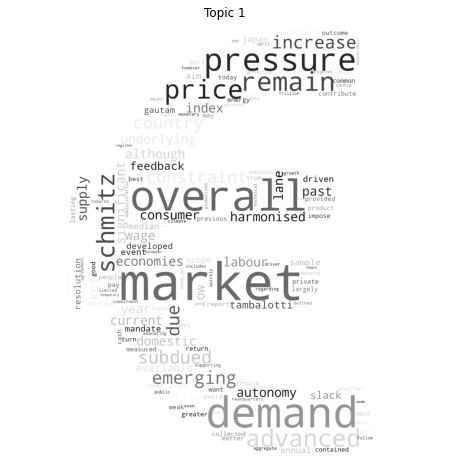

In [165]:
values = ','.join(str(v) for v in topics['Topic1']) 
# A similar function, but using the mask
def generate_better_wordcloud(data, title, mask=None):
    cloud = WordCloud(scale=3,
                      max_words=150,
                      colormap='bwr',
                      mask=mask,
                      background_color='black',
                      stopwords=stop,
                      collocations=True).generate_from_text(data)
    plt.figure(figsize=(8 ,8))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title)
    plt.show()
    
# Use the function with the rome_corpus and our mask to create word cloud     
generate_better_wordcloud(values, 'Topic 1', mask=euro)

### Choose sentences of certain topic relating to Economic conditions

In [ ]:
doc_topic = lda_model.transform(cv_features)
list_topic = []
for i in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[i].argmax()
    list_topic.append(topic_most_pr)
df_sent['topic'] = list_topic
df_sent.head(2)

In [256]:
sent6 = df_sent.loc[df_sent['topic']==6]
sent8= df_sent.loc[df_sent['topic']==8]
sent10 = df_sent.loc[df_sent['topic']==10]
sent12 = df_sent.loc[df_sent['topic']==12]
sent13 = df_sent.loc[df_sent['topic']==13]

In [260]:
sent_all = sent6.append(sent8).append(sent10).append(sent12).append(sent13)

In [262]:
sent_all.head(2)

,yymm,sent,topic
23,2020-12-01,[1] Stable inflation expectations in turn ensure that short-term deviations in inflation from the ECB’s medium-term target do not take hold in the price and wage decisions of companies and households,6
133,2020-12-01,"At the same time, respondents have split views regarding the measures taken by European institutions during the pandemic period: only 45 % of respondents view the crisis measures implemented to date favourably",6


In [1]:
sent1 = df_sent.loc[df_sent['topic']==1]
sent3= df_sent.loc[df_sent['topic']==3]
sent11 = df_sent.loc[df_sent['topic']==11]
sent12 = df_sent.loc[df_sent['topic']==12]
sent13 = df_sent.loc[df_sent['topic']==13]
sent14 = df_sent.loc[df_sent['topic']==14]
sent_all = sent1.append(sent3).append(sent11).append(sent12).append(sent13).append(sent14)
df_topsent = sent_all.reset_index(drop = True)
df_topsent.head(5)

NameError: name 'df_sent' is not defined

In [ ]:
!pip install vaderSentiment

### Data yield

https://sdw.ecb.europa.eu/quickview.do?SERIES_KEY=165.YC.B.U2.EUR.4F.G_N_A.SV_C_YM.SR_1Y&start=01-01-2018&end=31-05-2021&submitOptions.x=0&submitOptions.y=0&trans=MF


In [62]:
yie = pd.read_csv('yield.csv', sep = ';')
#yie.head(2)
yie = yie[['3m','1y','2y','5y','10y']]
yie0 = yie.sort_index(axis=0, ascending=False)
yie0 = yie0.reset_index(drop=True)
yie0.head(2)

,3m,1y,2y,5y,10y
0,-0.625430,-0.639447,-0.205301,0.046598,0.709876
1,-0.655109,-0.681066,-0.257543,0.011679,0.709144


In [68]:
ts_sent = pd.read_csv('ts_sent_nhap.csv', sep = ';')
ts_sent['yymm'] = ts_sent['Unnamed: 0']
ts_sent = ts_sent[['yymm','pos','neg','posneg','compound']]
ts_sent = ts_sent.iloc[1:41,:].reset_index()
ts_sent = ts_sent[['yymm','pos','neg','posneg','compound']]
ts_sent.head(2)
#
#
#
#
x = len(ts_sent)
num_index = range(0,x,1)
ts_sent =  ts_sent.reset_index(drop=True)
ts_sent.head()

,yymm,pos,neg,posneg,compound
0,2018-01-01,10.584,7.567,3.017,12.8740
1,2018-02-01,53.648,22.588,31.060,92.5362
2,2018-03-01,32.075,23.194,8.881,17.6964
3,2018-04-01,27.209,15.416,11.793,33.7946
4,2018-05-01,94.950,58.930,36.020,89.3245


In [70]:
import statsmodels.api as sm
x = ts_sent[['pos','neg']]
y = yie0['3m']
x = sm.add_constant(x)
model = sm.OLS(y,x).fit()
model.summary()

ValueError: The indices for endog and exog are not aligned